# Importing Header and SoilPrep

In [1]:
import import_ipynb 
from Header import *

importing Jupyter notebook from Header.ipynb


In [2]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb


## Loading Data and MetaData

In [3]:
import import_ipynb
from LoadDataMetaData import *

importing Jupyter notebook from LoadDataMetaData.ipynb


## Fixed One Time Resampling

In [4]:
mid_locs = ['420', '443', '490', '555', '638', '672', '702', '742', '782', '865', '910']
band_widths = [25, 40, 20, 20, 24, 16, 24, 16, 16, 20, 20]  

In [5]:
def resample_at (spectrum, mid_locs, band_widths):
    
    #----- obtaining the sampling ilocations in indx----
    mid_ilocs = []
    for l in mid_locs:
        #print(l)
        i = spectrum.columns.get_loc(l)
        mid_ilocs.append(i)
    
    #print(mid_ilocs)
    #print(mid_ilocs)
    #print(mid_locs)   
    
    #----- finding initial shape for red_spectra ------
    red_spectra = spectrum.iloc[:, mid_ilocs].copy()
    #print(red_spectra.head(5))
    #print(len(mid_ilocs))
    
    for i in range(0, len(mid_ilocs)):
        m = mid_ilocs[i]
        l = mid_locs[i]
        window = np.floor(0.5*band_widths[i]).astype(int)
        #print('m: ', m, 'window:', window)
        red_spectra.loc[:,l] = spectrum.iloc[:,(m-window):(m+window)].mean(axis=1).copy()
        
    return (red_spectra)


In [6]:
sampled_spec11 = resample_at (spec2[51], mid_locs, band_widths)
sampled_spec11.head(5)

,420,443,490,555,638,672,702,742,782,865,910
0,0.052008,0.058243,0.070345,0.114810,0.200542,0.223375,0.245792,0.273688,0.293500,0.31500,0.3270
1,0.054167,0.060743,0.073805,0.124350,0.215292,0.239937,0.264000,0.294313,0.316125,0.33915,0.3517
2,0.042587,0.046690,0.055260,0.092510,0.211417,0.239375,0.264708,0.292938,0.303875,0.30000,0.3050
3,0.047825,0.052785,0.063235,0.101105,0.179250,0.200500,0.221500,0.247563,0.266062,0.28530,0.2954
4,0.053779,0.062303,0.075350,0.123100,0.191375,0.203625,0.215750,0.229938,0.235875,0.23030,0.2280


In [7]:
sampled_cr11 = resample_at (cr_spec, mid_locs, band_widths)
#sampled_cr11.head(5)

In [8]:
sampled_log11 = resample_at(log_spec, mid_locs, band_widths)
#sampled_log11.head(5)

In [9]:
fod_sampled11 = fod (sampled_spec11)
#fod_sampled11.head(5)

In [10]:
fod_cr11 = fod (sampled_cr11)
#fod_cr10.head(5)

In [11]:
fod_log11 = fod (sampled_log11)
#fod_log11.head(5)

In [12]:
import os
os.system('say "your Meta Tree started building"')
import time

In [13]:
# prepare_spec = ['none', 'fod2', 'continuum', 'log']
# prepare_target = ['none', 'minmax']

def find_X(p):
    if p == 'fod':
        X = fod_sampled11
    elif p == 'cr':
        X = sampled_cr11
    elif p == 'log':
        X = sampled_log11
    elif p == 'none':
        X = sampled_spec11
    elif p == 'fod_cr':
        X = fod_cr11
    else:
        X = fod_log11
    return X

def find_spec(p, m):    
    spec = find_X(p)
    return spec    


def find_y(t):
    i = target_names.index(t) 
    y = T[i]
    return y
        
        

## Recording Hypertuning Parameters

In [14]:
from sklearn.metrics import make_scorer, r2_score

model ={}
param_grid ={}
model['mult'] = LinearRegression()
param_grid['mult'] = { 'fit_intercept': [True, False] }

model['ridge'] = KernelRidge()
param_grid['ridge']={'alpha': [ 0.00001,0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, \
                               0.005,  0.01, 0.05, 0.1, 0.5, 1]}

model['plsr'] = PLSRegression()
param_grid['plsr']={'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


model['cubist'] = Cubist(random_state = 42)  
param_grid['cubist'] = { 'n_committees': [5, 10, 15, 20], 'n_rules': [10, 20, 30, 40, 50] }
                        

model['gbrt'] = GradientBoostingRegressor(random_state = 42)
param_grid['gbrt'] = {
    'n_estimators': [30,40,50],        # Number of boosting stages to be used
    'learning_rate': [0.01, 0.1],     # Step size shrinkage used in updating weights
    'max_depth': [3, 4, 5]                # Maximum depth of individual trees
#     'min_samples_split': [2, 3],        # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2],         # Minimum number of samples required to be at a leaf node
}

model['svr'] = SVR()
param_grid['svr'] = {
    'C': [0.1, 1, 10],              # Regularization parameter
    'kernel': ['linear', 'rbf'],   # Kernel function
    'gamma': [0.01, 0.1, 1],      # Kernel coefficient (only for 'rbf' kernel)
}


### Finding Hypertuned Parameters

In [15]:
# def find_core_model_param_on (m, t, p, tp, n):
#     Model = model[m]
#     X = find_spec(p,n,m)
#     y = find_y(t, tp)
    
#     row, col = X.shape

#     scorer = make_scorer(mean_squared_error, greater_is_better=False)
#     cv = RepeatedKFold(n_splits=row, n_repeats=1, random_state=3)
        
#     grid_search = GridSearchCV(Model, param_grid=param_grid[m], cv=cv,\
#                                 scoring= scorer, refit=True, verbose=1, error_score='raise', n_jobs=-1)
#     grid_search.fit(X,y)
    
#     return (grid_search.best_params_)

def find_tuned_param_on (X_train, y_train, m):
    Model = model[m]
    X = X_train
    y = y_train
    
    row, col = X.shape

    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    cv = RepeatedKFold(n_splits=row, n_repeats=1, random_state=3)
        
    grid_search = GridSearchCV(Model, param_grid=param_grid[m], cv=cv,\
                                scoring= scorer, refit=True, verbose=1, error_score='raise', n_jobs=-1)
    grid_search.fit(X,y)
    
    return (grid_search.best_params_)
    

### Creating Hypertuned Models

In [16]:
def create_core_model_on (m, BP):
    if m == 'mult':
        Model = LinearRegression()
        
    elif m == 'ridge':
        Model =  KernelRidge(alpha = BP['alpha'])
        
    elif m == 'plsr':
        Model = PLSRegression(n_components = BP['n_components'])
        
    elif m == 'cubist':
        Model =  Cubist( n_committees = BP['n_committees'], n_rules = BP['n_rules'], random_state = 42) 
    
    elif m == 'gbrt':
        Model = GradientBoostingRegressor(n_estimators = BP['n_estimators'], learning_rate = BP['learning_rate'], \
                                          max_depth = BP['max_depth'],  random_state = 42)
    elif m == 'svr':
        Model = SVR(C = BP['C'], kernel = BP['kernel'], gamma = BP['gamma'])
        
    return Model    
            

## Building HMtree and BPtree

In [17]:
ml_methods = ['mult', 'ridge', 'plsr', 'svr', 'cubist', 'gbrt']

In [18]:
def L1_y_pred (spectra, target, method, bp):
    m = method
    (r,c) = spectra.shape
    
    Y_test = target.copy()
    Y_pred = target.copy()
    #print('r:', r)
    for i in range (0, r): 
        #print('i: ', i)
        full_spec = spectra.copy()
        X_train = full_spec.drop(full_spec.index[i], axis=0)
        X_test = full_spec.iloc[[i],:].copy()
        full_tar = target.copy()
        y_train = full_tar.drop(full_tar.index[i], axis=0)
        y_test = full_tar.iloc[i].copy()        
        #---- Model Creation, fitting, and predictions--------
        Model = create_core_model_on (m, bp)
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test)
        Y_pred.iloc[i] = y_pred
        
    return Y_pred      

Training set: (43, 11), (43,)
Test set: (43, 11), (43,)


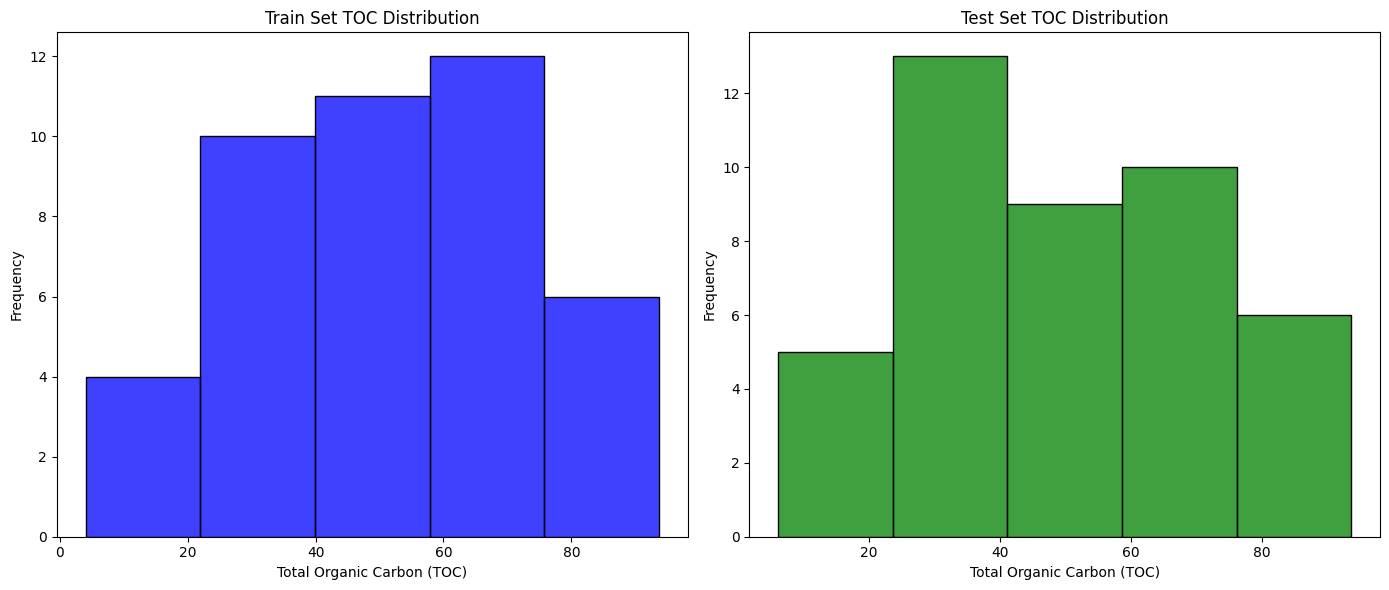

In [30]:
t = 'Sand'
m = 'cubist'
p ='none'

spec = find_spec(p, m)  
y = find_y(t)

num_bins = 5  # Adjust this number based on your needs
Y_binned, bin_edges = pd.qcut(y, q=num_bins, labels=False, retbins=True)
X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= 0.5, stratify=Y_binned, random_state=0)

print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Y_train_df = pd.DataFrame(y_train, columns=['TOC'])
Y_test_df = pd.DataFrame(y_test, columns=['TOC'])

# Plot histograms of the train and test sets
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=num_bins, kde=False, color='blue', edgecolor='black')
plt.title('Train Set TOC Distribution')
plt.xlabel('Total Organic Carbon (TOC)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(y_test, bins=num_bins, kde=False, color='green', edgecolor='black')
plt.title('Test Set TOC Distribution')
plt.xlabel('Total Organic Carbon (TOC)')
plt.ylabel('Frequency')

plt.tight_layout()


In [20]:
halt here

SyntaxError: invalid syntax (3817168042.py, line 1)

In [ ]:
def build_HMtree_on (method_name, target):
    
    tree ={}
    
    start = time.time()
    m = method_name
    t = target
    
    print('tree for: '+ m +' ------> running on: ' + t)
    
    for tp in prepare_target:
        tree[tp] ={}        
        for p in prepare_spec:
            tree[tp][p] ={}            
            
            Y = tree[tp][p]
                                           
            #------ setting spec to appropriate (sampled) spectra----                
            spec = find_spec(p, m)                
                                        
            #---- target selection and normalization ---
            y = find_y(t)
                                
            #---- performing train-test split----------------------
            X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= 0.3, random_state=42)
                            
            #----- hypertuning parameter, model creation, fitting and prediction ----                
                
            #bp = find_tuned_param_on (X_train, y_train, m)
            bp = find_tuned_param_on (spec, y, m)
                
            Y['bp'] = bp
            print('Method: '+ m + '---> Target: '+ t+ '----> SpecProc: ' +p+ ' ---> n_band: 11')
            Model = create_core_model_on (m, bp)
            Model.fit(X_train, y_train)
                
            y_pred = Model.predict(X_test)
            yhat_pred = Model.predict(X_train)
                    
            #----- Data for Model accuracy and plotting -----------
            Y['X_test'] = X_test                
            Y['y_test'] = y_test
            Y['y_testP'] = y_pred
                
            Y['X_train'] = X_train
            Y['y_train'] = y_train
            Y['y_trainP'] = yhat_pred
                    
            Y['iqrp_test'] = find_iqrp(y_pred, y_test)
            Y['r2_test'] = find_r2(y_pred, y_test)
            Y['rpd_test'] = find_rpd(y_pred, y_test)                 
                
            Y['r2_train'] = find_r2(yhat_pred, y_train)
                
            #------- L1 out prediction on test data -----------------
            L1y_pred = L1_y_pred (spec, y, m, bp)
            Y['L1y_testP'] = L1y_pred
            Y['L1y_test'] = y
             
            
            Y['L1iqrp_test'] = find_iqrp(L1y_pred, y)
            Y['L1r2_test'] = find_r2(L1y_pred, y)
            Y['L1rpd_test'] = find_rpd(L1y_pred, y) 
                
                                                                         
    end = time.time()                            
    os.system('say "your hyper tuned meta tree finished for one more method"')                            

    print('End time - Start time =', (end-start)) 
    
    return tree.copy()

In [ ]:
def build_HMtree_for (method_name):
    tree ={}
    
    start = time.time()
    m = method_name
    for t in target_names:
        #print('tree for: '+ m +' ------> running on: ' + t)
        tree[t] = build_HMtree_on (m, t)
        
    end = time.time()                            
    os.system('say "your meta tree finished for one more method"')                            
    print('End time - Start time =', (end-start))     
    return tree.copy()

In [ ]:
def best_score_on (HMtree, target, method, scorer):
    t=target
    m= method
    
    best_score = -1
    #best_n_comp = 'NA'
    
    
    for tp in prepare_target:
        for p in prepare_spec:
            
            Y = HMtree[m][t][tp][p]
            #r2_train = Y['r2_train']
            #r2_test = Y['r2_test']
            #L1r2_test = Y['L1r2_test']
                 
                    
            if scorer == 'iqrp':
                cur_score = Y['iqrp_test']
            elif scorer == 'L1iqrp':
                cur_score = Y['L1iqrp_test']
            elif scorer == 'r2':
                cur_score = Y['r2_test'] 
            else:
                cur_score = Y['L1r2_test']  
                    
            if cur_score > best_score:
                best_score = cur_score
                best_tp = tp
                best_n = 13
                best_p = p
                            
    param_list = [scorer, np.round(best_score,2), 'Spec:', best_p, 'bands: 11']                                 
    return (param_list)          

In [ ]:
def best_score_for (HMtree, target, scorer):
    
    for method in ml_methods:
        param_list= best_score_on (HMtree, target, method, scorer)
        print('For:'+target+'->', param_list, ':'+method)
     
    return

In [ ]:
with open ('HMtree.pickle', 'rb') as file:
    HMtree = pickle.load(file)
 

## Creating different branches of Mtree (for separate methods)

In [ ]:
#HMtree = {}

In [ ]:
# HMtree['mult'] = build_HMtree_for('mult')
# HMtree['plsr'] = build_HMtree_for('plsr')
# HMtree['svr'] = build_HMtree_for('svr')
# HMtree['ridge'] = build_HMtree_for('ridge')
# HMtree['cubist'] = build_HMtree_for('cubist')
# HMtree['gbrt'] = build_HMtree_for('gbrt')

In [ ]:
# with open ('HMtree.pickle', 'wb') as file:
#     pickle.dump(HMtree, file)
        

In [ ]:
#Plotting Model Accuracy (ipywidgets)
def plot_model_acc_half (method, target, spec_preprocessing):
    
    m = method
    t = target
    
    i = target_names.index(target)    
    
    p = spec_preprocessing
    #n = n_bands
    tp = 'none'
    
    Y = HMtree[m][t][tp][p]
    
    y_test = Y['y_test']
    y_pred = Y['y_testP']
    L1y_pred = Y['L1y_testP']
    L1y_test = Y['L1y_test']
    

    
    if m == 'plsr':
        y_pred = y_pred[:,0]
        #L1y_pred = L1y_pred[:,0]

    
    iqrp_test = Y['iqrp_test']
    r2_test = Y['r2_test']
    rpd_test = Y['rpd_test']
    
    L1iqrp_test = Y['L1iqrp_test']
    L1r2_test = Y['L1r2_test']
    L1rpd_test = Y['L1rpd_test']
    
    y_tp = pd.DataFrame({'actual':y_test.values, 'predic': y_pred})
    z = np.polyfit(y_test, y_pred, 1)
    
    L1y_tp = pd.DataFrame({'actual':L1y_test.values, 'predic': L1y_pred})
    L1z = np.polyfit(L1y_test, L1y_pred, 1)
    
    fig, (axes1,axes2) = plt.subplots(1,2, figsize=(10,5))
    plt. grid(False)
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    y_tp.plot.scatter(ax= axes1, x="actual", y="predic", alpha=1.0, color = clr[i], edgecolors='k')
    axes1.plot(y_test, np.polyval(z, y_test),  c='blue', linewidth=1)
    axes1.plot(y_test, y_test, color='green', linewidth=1)
    axes1.tick_params(axis='both', labelsize=10)
    axes1.text(0.05, 0.95, target_names[i]+' (Train-Test Score)', transform=axes1.transAxes, fontsize = 14, color = clr[i])
    axes1.text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_test), transform=axes1.transAxes, fontsize = 11)
    axes1.text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_test), transform=axes1.transAxes, fontsize = 11)
    axes1.text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_test,3)), transform=axes1.transAxes, fontsize = 11)
    axes1.text(0.95, 0.15, 'Method: '+method, transform=axes1.transAxes, 
                    horizontalalignment='right', fontsize = 12)
    
    L1y_tp.plot.scatter(ax= axes2, x="actual", y="predic", alpha=1.0, color = clr[i], edgecolors='k')
    axes2.plot(L1y_test, np.polyval(L1z, L1y_test),  c='blue', linewidth=1)
    axes2.plot(L1y_test, L1y_test, color='green', linewidth=1)
    axes2.tick_params(axis='both', labelsize=10)
    axes2.text(0.05, 0.95, target_names[i]+' (L1-out Score)', transform=axes2.transAxes, fontsize = 14, color = clr[i])
    axes2.text(0.05, 0.90, 'IQRP ={:.2f}'.format(L1iqrp_test), transform=axes2.transAxes, fontsize = 11)
    axes2.text(0.05, 0.85, 'RPD ={:.2f}'.format(L1rpd_test), transform=axes2.transAxes, fontsize = 11)
    axes2.text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(L1r2_test,3)), transform=axes2.transAxes, fontsize = 11)
    axes2.text(0.95, 0.15, 'Method: '+method, transform=axes2.transAxes, 
                    horizontalalignment='right', fontsize = 12)
    
    return


In [ ]:
#ml_methods = ['mult', 'ridge', 'plsr', 'svr', 'cubist', 'gbrt']

ml_methods = ['mult', 'plsr', 'svr', 'ridge', 'cubist','gbrt']

In [ ]:
#best_score_for (HMtree, 'Sand', 'r2')

In [ ]:
best_score_for (HMtree, 'Sand', 'L1r2')

In [ ]:
#best_score_for (HMtree, 'Silt', 'r2')

In [ ]:
best_score_for (HMtree, 'Silt', 'L1r2')

In [ ]:
#best_score_for (HMtree, 'Clay', 'r2')

In [ ]:
best_score_for (HMtree, 'Clay', 'L1r2')

In [ ]:
#best_score_for (HMtree, 'TOC', 'r2')

In [ ]:
best_score_for (HMtree, 'TOC', 'L1r2')

In [ ]:
#best_score_for (HMtree, 'CaCO3', 'r2')

In [ ]:
best_score_for (HMtree, 'CaCO3', 'L1r2')

## Plotting Model Accuracy (ipywidgets)

In [ ]:
ipywidgets.interact( plot_model_acc_half, target = target_names, method = ml_methods, \
                    spec_preprocessing = prepare_spec,  \
                    target_preprocessing = prepare_target)

In [ ]:
# with open ('HMtree.pickle', 'wb') as file:
#     pickle.dump(HMtree, file)

In [ ]:
# MTable = {'Input': ['Hyperspectral', 'Sentinal', 'Venus'], 
#           'Target': ['Sand', 'Sand', 'Sand'], 
#           'plsr': ['R2:0.57  bands:13','R2:0.57 bands:13','R2:0.57  bands:13'],
#           'cubist': ['R2:0.57  bands:13','R2:0.57 bands:13','R2:0.57  bands:13'],
#           'gbrt': ['R2:0.57  bands:13','R2:0.57 bands:13','R2:0.57  bands:13'],
#           'svr': ['R2:0.57  bands:13','R2:0.57 bands:13','R2:0.57  bands:13'],
#           'kridge': ['R2:0.57  bands:13','R2:0.57 bands:13','R2:0.57  bands:13']}
          

In [ ]:
#MTable = pd.DataFrame.from_dict(MTable)


In [ ]:
#pd.set_option('display.colheader_justify', 'center')

In [ ]:
#MTable